In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# LSTM 車流量分析

## 套件載入

In [2]:
# Core Keras libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional

# For data conditioning
from scipy.ndimage import gaussian_filter1d
from scipy.signal import medfilt

# Make results reproducible
from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(1)

# Other essential libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math

# Make our plot a bit formal
font = {
    'family': 'Arial',
    'weight': 'normal',
    'size': 10
}
plt.rc('font', **font)

## 資料載入

In [3]:
dataset = pd.read_csv('./data1.csv')
dataset.head(48)

,時間,小時,平均車速,交通量,週次,週次標註
0,1/1,0,85.032220,9249,1,0
1,1/1,1,85.392148,9068,1,0
2,1/1,2,85.181213,8719,1,0
3,1/1,3,85.361773,8392,1,0
4,1/1,4,85.097737,8615,1,0
5,1/1,5,85.283288,8419,1,0
6,1/1,6,85.256781,9475,1,0
7,1/1,7,84.547136,9568,1,0
8,1/1,8,84.317396,9600,1,0
9,1/1,9,83.793958,10294,1,0


## 設置 epoch、time stamp



In [19]:
n_timestamp = 24 * 2    # 根據資料可以看出每列資料式一小時，這裡設定參考 2 天
n_epochs = 25
filter_on = True       # 是否做資料處理
model_type = 1        # 1.Single cell LSTM 2.Stacked LSTM 3.Bidirectional LSTM
train_test_split = 0.8    # train 比例，以天做計算
dataset_column = '交通量'   # 要預測的欄位

## 資料處理

### 資料集做中值過濾 + 高斯過濾

In [20]:
def med_gau_filter(data, med_kernel=3, gau_kernel=1.2):
    data = medfilt(data, med_kernel)
    data = gaussian_filter1d(data, gau_kernel)
    return data
if filter_on:
    dataset[dataset_column] = med_gau_filter(dataset[dataset_column])

### 設置訓練、測試資料集

In [21]:
datalen = int(len(dataset) // 24 * .8) * 24
train_set = dataset[: datalen]
test_set = dataset[datalen: ]

training_set = tf.expand_dims(train_set[dataset_column], -1)
testing_set = tf.expand_dims(test_set[dataset_column], -1)

### 正規化(normalize) 資料，使資料值介於[0, 1]

In [22]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.fit_transform(testing_set)

### 產生 X, Y 資料集(reshape into X=t and Y=t+1)

In [23]:
def data_split(sequence, n_timestamp):
    dataX, dataY = [], []
    for i in range(len(sequence) - n_timestamp - 1):
        seq_x, seq_y = sequence[i: (i+n_timestamp), :], sequence[i + n_timestamp , :]
        dataX.append(seq_x)
        dataY.append(seq_y)
    return np.array(dataX), np.array(dataY)

X_train, y_train = data_split(training_set_scaled, n_timestamp)
X_test, y_test = data_split(testing_set_scaled, n_timestamp)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## 建構 LSTM 模型

In [24]:
def build_lstm_model(X_train, model_type = 2):
    if model_type == 1:
        # Single cell LSTM
        model = Sequential()
        model.add(LSTM(units = 50, activation='relu', input_shape = (X_train.shape[1], 1)))
        model.add(Dense(units = 1))
    
    if model_type == 2:
        # Stacked LSTM
        model = Sequential()
        model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
        model.add(LSTM(50, activation='relu'))
        model.add(Dense(1))

    if model_type == 3:
        # Bidirectional LSTM
        model = Sequential()
        model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(X_train.shape[1], 1)))
        model.add(Dense(1))

    return model

model = build_lstm_model(X_train, model_type)
model.compile(optimizer = 'adam', loss= 'mean_squared_error')

## 模型訓練

In [25]:
history = model.fit(X_train, y_train, epochs = n_epochs, batch_size= 32)
loss = history.history['loss']
epochs = range(len(loss))

Epoch 1/25
218/218 [==============================] - 2s 11ms/step - loss: 0.0391
Epoch 2/25
218/218 [==============================] - 2s 11ms/step - loss: 0.0160
Epoch 3/25
218/218 [==============================] - 2s 11ms/step - loss: 0.0109
Epoch 4/25
218/218 [==============================] - 2s 10ms/step - loss: 0.0033
Epoch 5/25
218/218 [==============================] - 2s 10ms/step - loss: 0.0017
Epoch 6/25
218/218 [==============================] - 2s 10ms/step - loss: 0.0013
Epoch 7/25
218/218 [==============================] - 2s 11ms/step - loss: 0.0012
Epoch 8/25
218/218 [==============================] - 2s 11ms/step - loss: 9.2025e-04
Epoch 9/25
218/218 [==============================] - 2s 11ms/step - loss: 6.7752e-04
Epoch 10/25
218/218 [==============================] - 2s 11ms/step - loss: 5.0840e-04
Epoch 11/25
218/218 [==============================] - 2s 11ms/step - loss: 3.6216e-04
Epoch 12/25
218/218 [==============================] - 2s 10ms/step - loss: 3.00

## 要用測試資料集來預測資料，所以將資料轉換回原始值

In [26]:
# train
x_train_predicted = model.predict(X_train)
x_train_predicted_descaled = sc.inverse_transform(x_train_predicted)
y_train_descaled = sc.inverse_transform(y_train)

# test
x_test_predicted = model.predict(X_test)
x_test_predicted_descaled = sc.inverse_transform(x_test_predicted)
y_test_descaled = sc.inverse_transform(y_test)

## 計算 MSE、RMSE、R2
    R2: 結果接近1，模型越好；結果接近0，模型越差

In [27]:
mse = mean_squared_error(y_test_descaled, x_test_predicted_descaled)
rmse = np.sqrt(mean_squared_error(x_test_predicted_descaled, y_test_descaled))
r2 = r2_score(y_test_descaled, x_test_predicted_descaled)

print('mse = \t' + str(round(mse, 5)))
print('rmse = \t' + str(round(rmse, 5)))
print('r2 = \t' + str(round(r2, 5)))

mse = 	1683.91746
rmse = 	41.03556
r2 = 	0.99606


## 訓練、測試、原始資料趨勢圖

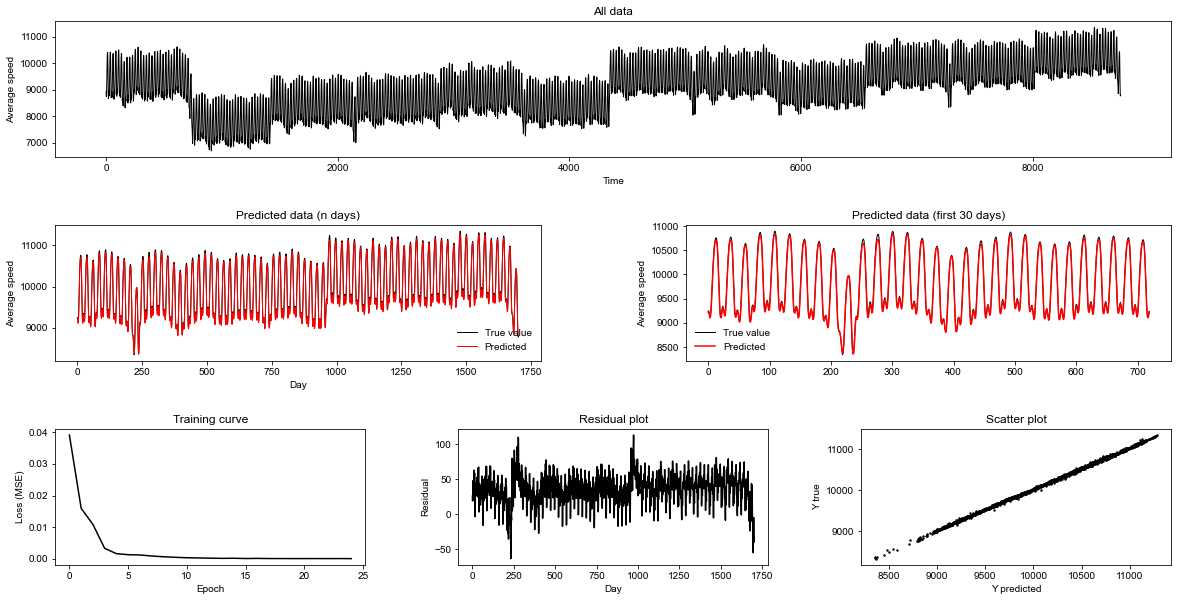

In [30]:
plt.figure(figsize=(20, 10))

# 觀察 原始資料，x = 原始資料、y = 時間
plt.subplot(3, 1, 1)
plt.plot(dataset[dataset_column], color='black', linewidth=1, label='True value')
plt.ylabel('Average speed')
plt.xlabel('Time')
plt.title('All data')

# 觀察 預測資料 (n 天)
plt.subplot(3, 2, 3)
plt.plot(y_test_descaled, color='black', linewidth=1, label='True value')
plt.plot(x_test_predicted_descaled, color='red', linewidth=1, label='Predicted')
plt.legend(frameon=False)
plt.ylabel('Average speed')
plt.xlabel('Day')
plt.title('Predicted data (n days)')

# 觀察 指定 預測天數的資料
plt.subplot(3, 2, 4)
plt.plot(y_test_descaled[0: 24 * 30], color='black', linewidth=1, label='True value')
plt.plot(x_test_predicted_descaled[0: 24 * 30], color='red', label='Predicted')
plt.legend(frameon=False)
plt.ylabel('Average speed')
plt.title('Predicted data (first 30 days)')

# 顯示訓練曲線
plt.subplot(3, 3, 7)
plt.plot(epochs, loss, color='black')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.title('Training curve')

# 殘差圖- 觀測誤差用，用於檢驗模型的適當性
plt.subplot(3, 3, 8)
plt.plot(y_test_descaled - x_test_predicted_descaled, color='black')
plt.ylabel('Residual')
plt.xlabel('Day')
plt.title('Residual plot')

# 散點圖- 展示數據的分布、聚合情況，並觀察趨勢
plt.subplot(3, 3, 9)
plt.scatter(x_test_predicted_descaled, y_test_descaled, s=2, color='black')
plt.ylabel('Y true')
plt.xlabel('Y predicted')
plt.title('Scatter plot')

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

## 儲存模型

In [29]:
# import os
# model.save(os.path.join('C:/Users/PC/Desktop/ETC/731', 'last.h5'))